# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак: Price — цена (евро)

## Подготовка данных

### Ознакомление с данными и удаление неинформативных признаков

In [ ]:
#импортируем необходимые для работы библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
import catboost
import lightgbm
from sklearn.dummy import DummyRegressor

In [ ]:
#считаем датасет и сохраним его в переменной

pth1 = '/datasets/autos.csv'
pth2 = 'https://code.s3.yandex.net/datasets/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Ошибка')

In [ ]:
data.head() #выведем первые 5 строк получившегося датафрейма

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


В датафрейме присутствуют неинформативные признаки, которые никак не влияют на целевой - стоимость автомобиля - но могут запутать модель. Это столбцы, содержащие дату скачивания анкеты из базы, месяц регистрации автомобиля, дату создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты (пользователя) и дату последней активности пользователя. Сразу удалим все эти столбцы, кроме даты выгрузки из базы - этот столбец понадобится нам позже для выявления аномалий.

In [ ]:
data = data.drop(columns=['RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'])
data.head() #посмотрим на первые пять строк обновлённого датафрейма

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [ ]:
data.info() #теперь выведем основную информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DateCrawled       354369 non-null  datetime64[ns]
 1   Price             354369 non-null  int64         
 2   VehicleType       316879 non-null  object        
 3   RegistrationYear  354369 non-null  int64         
 4   Gearbox           334536 non-null  object        
 5   Power             354369 non-null  int64         
 6   Model             334664 non-null  object        
 7   Kilometer         354369 non-null  int64         
 8   FuelType          321474 non-null  object        
 9   Brand             354369 non-null  object        
 10  Repaired          283215 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 29.7+ MB


### Обработка пропусков

Мы видим, что в датафрейме присутствуют пропуски. Построим диаграмму, чтобы подробнее изучить их.

In [ ]:
#создадим функцию, которая строит горизонтальную столбчатую диаграмму с количеством пропусков в столбцах датафрейма
#на графике будут показаны только столбцы с пропусками
def pass_value_barh(df):
    try:
        (df.isna().sum()
            .to_frame()
            .rename(columns = {0:'Количество_пропусков'})
            .query('Количество_пропусков > 0')
            .sort_values(by = 'Количество_пропусков', ascending = True)
            .plot(kind = 'barh', figsize = (15,10), title='Столбцы с пропусками и их количество', xlabel='Название столбца', ylabel='Количество пропусков')
        )
        plt.xlabel('Количество пропусков');

    except:
        print('Ошибка')

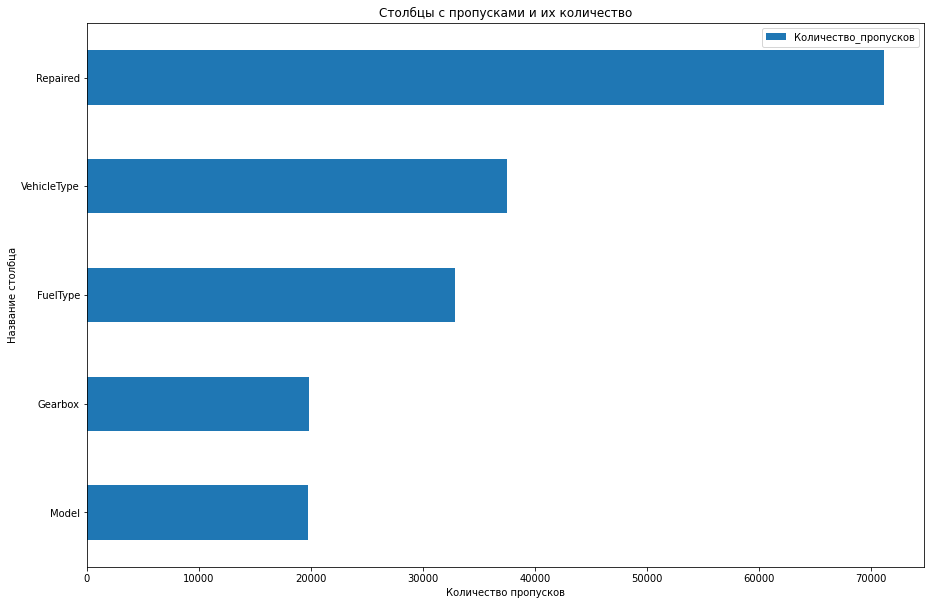

In [ ]:
#посмотрим на график с количеством пропусков в датафрейме
pass_value_barh(data)

In [ ]:
#также посмотрим на точное количество пропусков в датафрейме
data.isna().sum().sort_values(ascending=False)

Repaired            71154
VehicleType         37490
FuelType            32895
Gearbox             19833
Model               19705
DateCrawled             0
Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
Brand                   0
dtype: int64

Мы видим, что все пропуски в столбцах с категориальными данными - была машина в ремонте или нет, тип автомобильного кузова, тип топлива, тип коробки передач, модель автомобиля. Нам не представляется возможным восстановить пропуски, поэтому заполним их значением 'unknown'.

In [ ]:
def fill(columns):
    for column in columns:
        data[column] = data[column].fillna('unknown')

fill(['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model'])

In [ ]:
#удостоверимся, что все пропуски заполнены
data.isna().sum().sort_values(ascending=False)

DateCrawled         0
Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

### Обработка дубликатов

Проверим, есть ли в датафрейме полные дубликаты.

In [ ]:
print('Количество полных дубликатов в датафрейме:', data.duplicated().sum())

Количество полных дубликатов в датафрейме: 25


Удалим их.

In [ ]:
data = data.drop_duplicates()

Убедимся, что дубликатов не осталось.

In [ ]:
print('Количество полных дубликатов в датафрейме после удаления:', data.duplicated().sum())

Количество полных дубликатов в датафрейме после удаления: 0


### Обработка аномалий

Теперь посмотрим на распределение данных в датафрейме с помощью метода describe().

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354344.000000,354344.000000,354344.000000,354344.000000
mean,4416.561477,2004.234563,110.091352,128212.330391
std,4514.167328,90.231117,189.855996,37904.408738
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Для категориальных признаков построим столбчатые диаграммы, а для количественных - "ящик с усами".

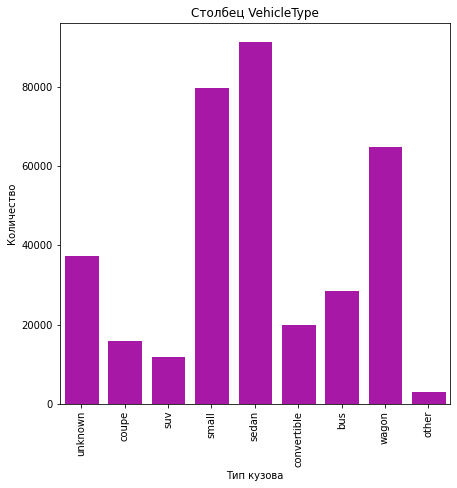

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
sns.set_style('whitegrid')
plt.xticks(rotation=90)
sns.countplot(x=data['VehicleType'], color='m').set(title='Столбец VehicleType')
ax.set(ylabel="Количество", xlabel="Тип кузова")
plt.show();

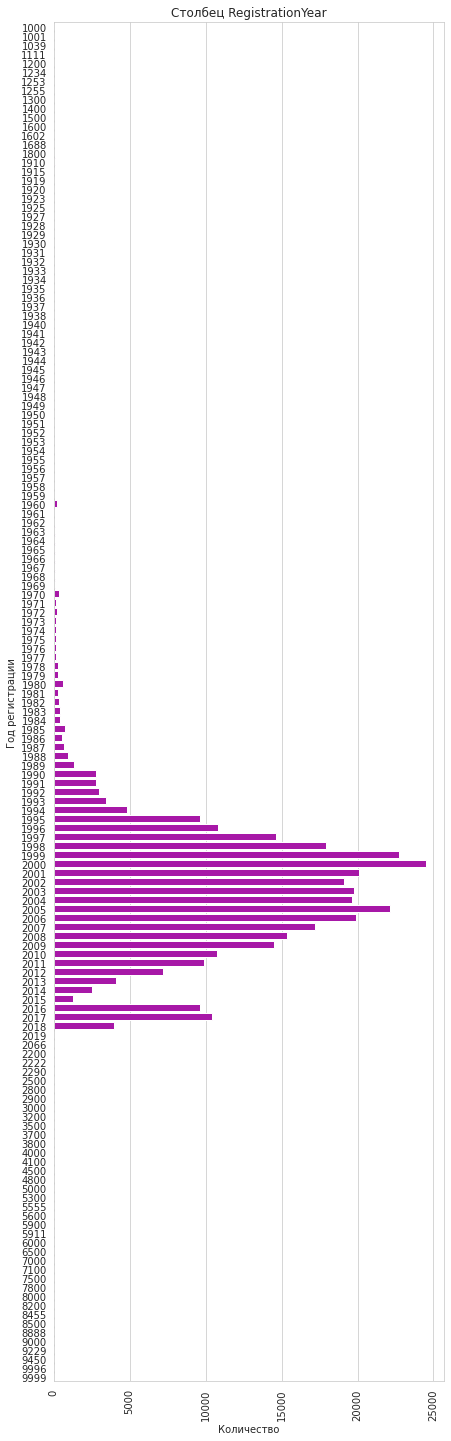

In [ ]:
f, ax = plt.subplots(figsize=(7, 25))
sns.set_style('whitegrid')
plt.xticks(rotation=90)
sns.countplot(y=data['RegistrationYear'], color='m').set(title='Столбец RegistrationYear')
ax.set(ylabel="Год регистрации", xlabel="Количество")
plt.show();

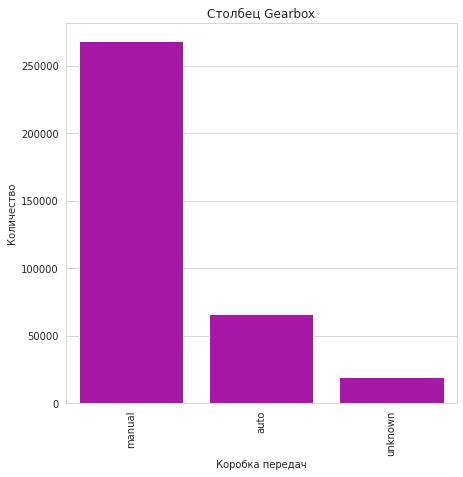

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
sns.set_style('whitegrid')
plt.xticks(rotation=90)
sns.countplot(x=data['Gearbox'], color='m').set(title='Столбец Gearbox')
ax.set(ylabel="Количество", xlabel="Коробка передач")
plt.show();

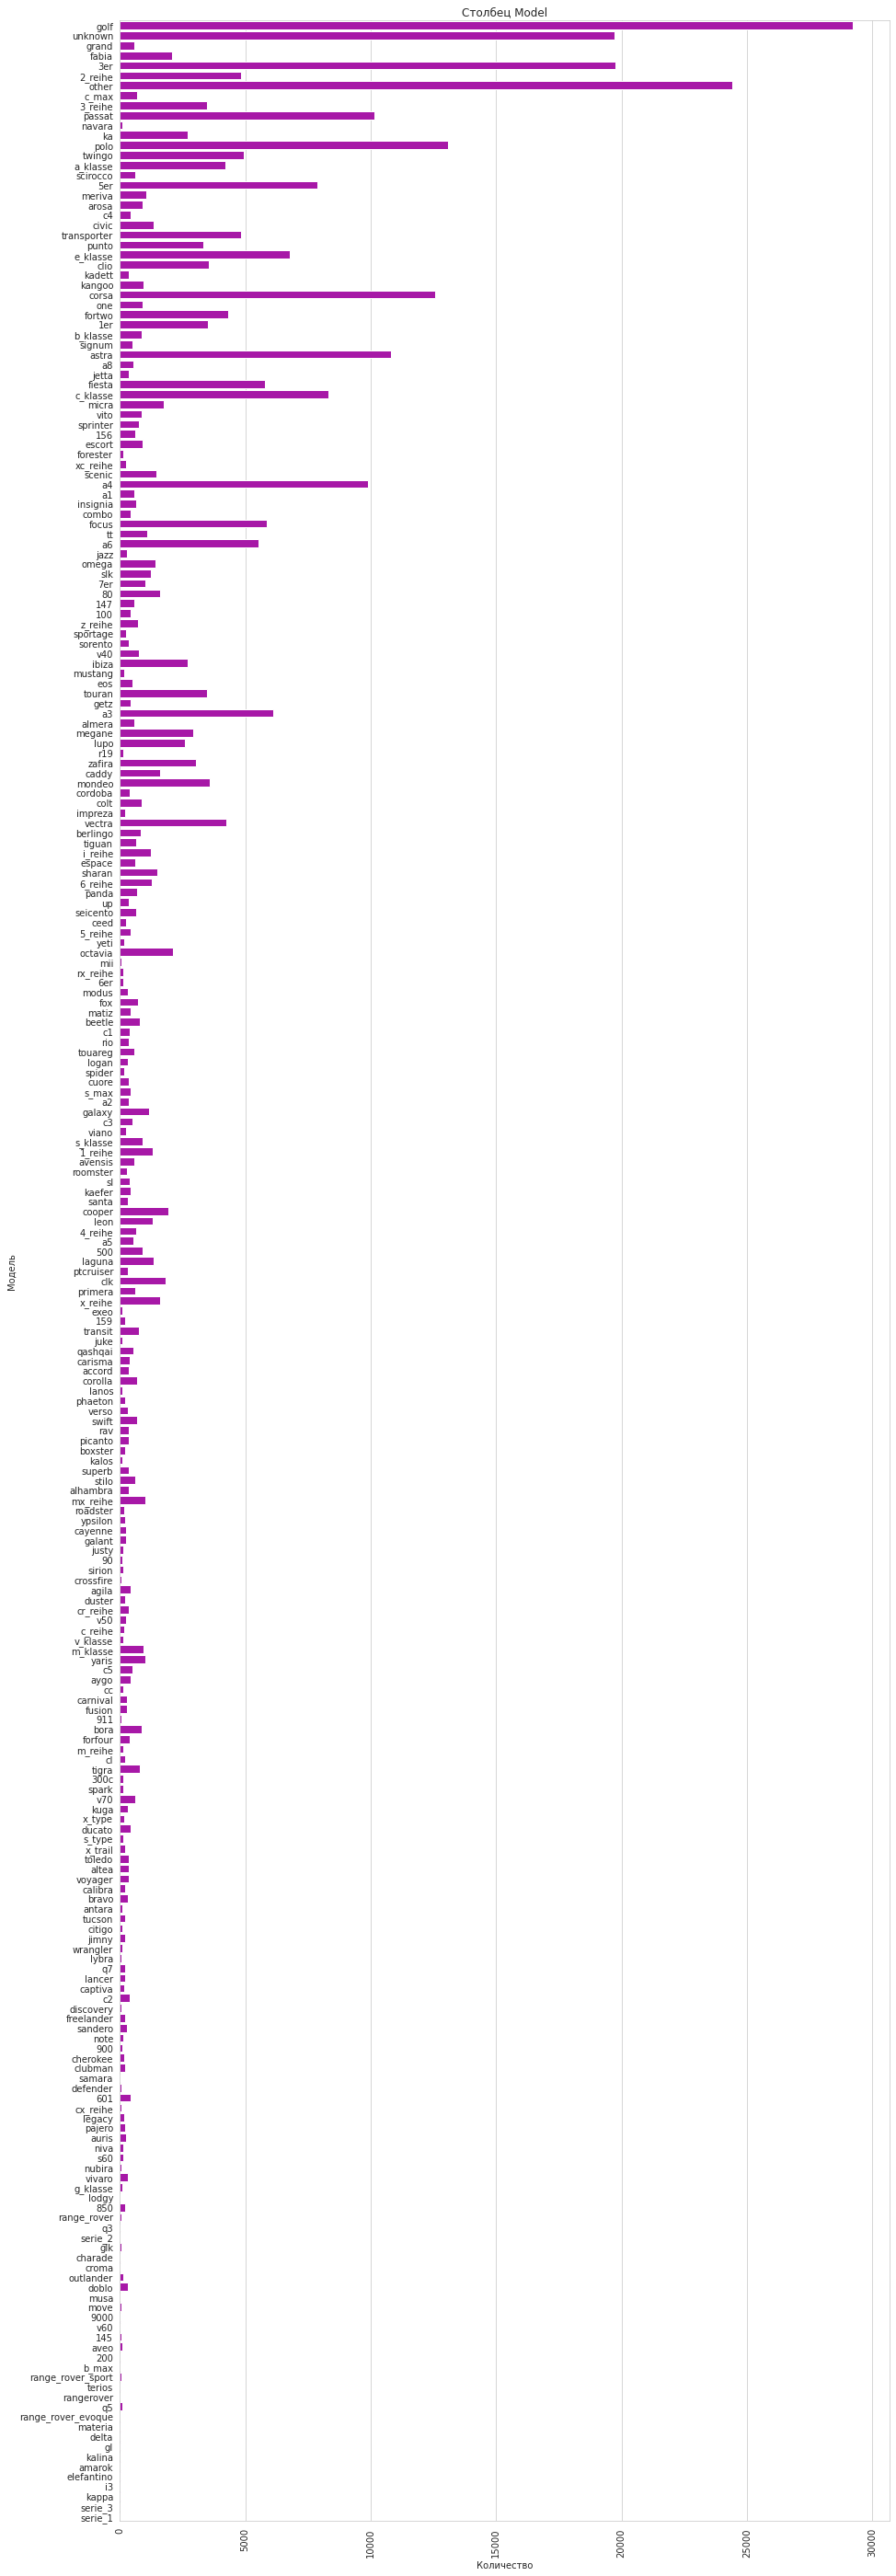

In [ ]:
f, ax = plt.subplots(figsize=(15, 50))
sns.set_style('whitegrid')
plt.xticks(rotation=90)
sns.countplot(y=data['Model'], color='m').set(title='Столбец Model')
ax.set(ylabel="Модель", xlabel="Количество")
plt.show();

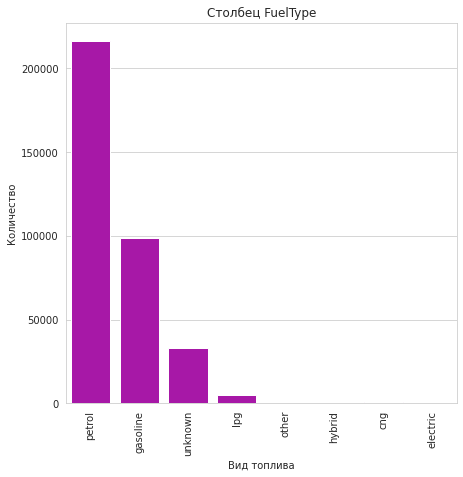

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
sns.set_style('whitegrid')
plt.xticks(rotation=90)
sns.countplot(x=data['FuelType'], color='m').set(title='Столбец FuelType')
ax.set(ylabel="Количество", xlabel="Вид топлива")
plt.show();

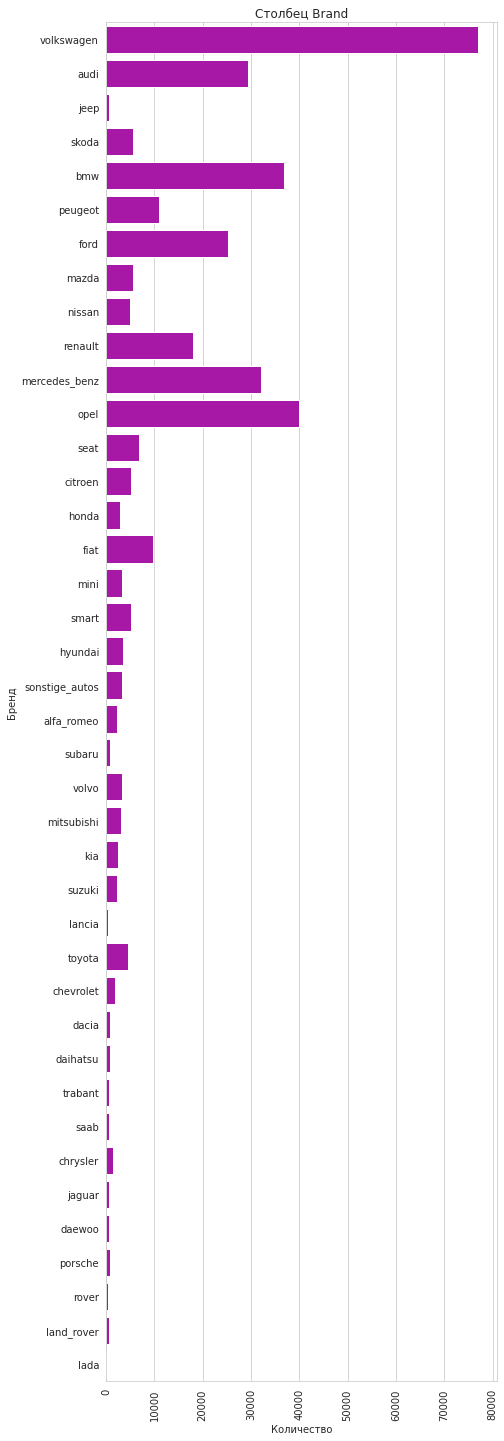

In [ ]:
f, ax = plt.subplots(figsize=(7, 25))
sns.set_style('whitegrid')
plt.xticks(rotation=90)
sns.countplot(y=data['Brand'], color='m').set(title='Столбец Brand')
ax.set(ylabel="Бренд", xlabel="Количество")
plt.show();

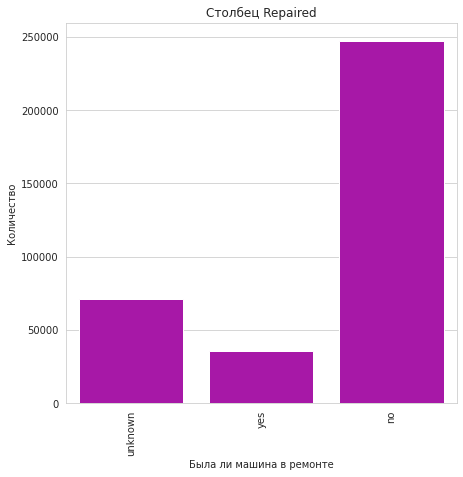

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
sns.set_style('whitegrid')
plt.xticks(rotation=90)
sns.countplot(x=data['Repaired'], color='m').set(title='Столбец Repaired')
ax.set(ylabel="Количество", xlabel="Была ли машина в ремонте")
plt.show();

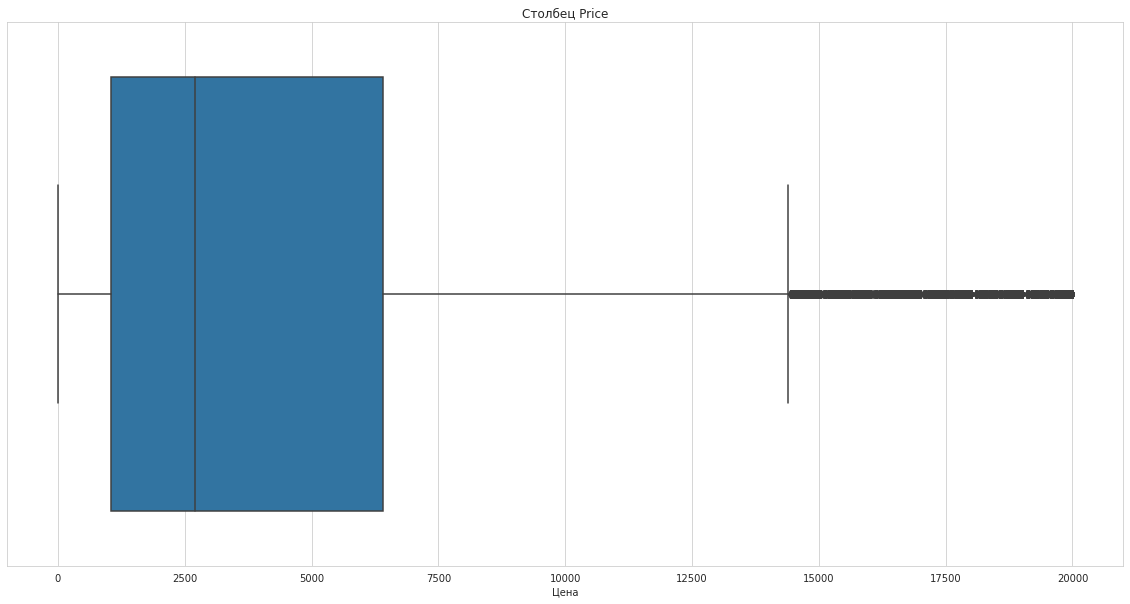

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_style('whitegrid')
sns.boxplot(x=data['Price']).set(title='Столбец Price')
ax.set(ylabel="", xlabel="Цена")
plt.show();

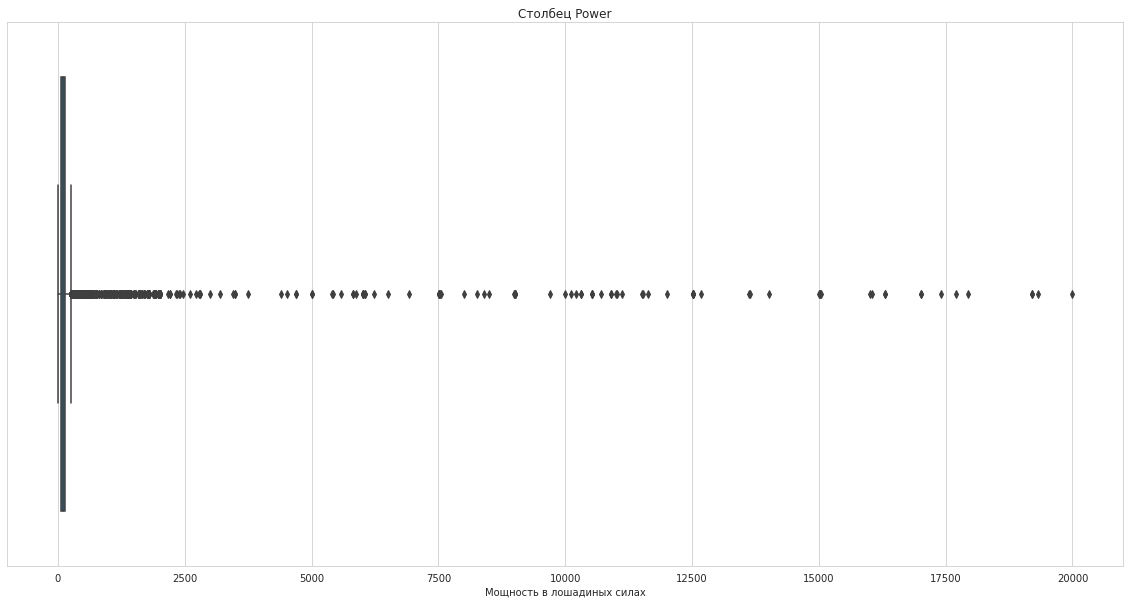

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_style('whitegrid')
sns.boxplot(x=data['Power']).set(title='Столбец Power')
ax.set(ylabel="", xlabel="Мощность в лошадиных силах")
plt.show();

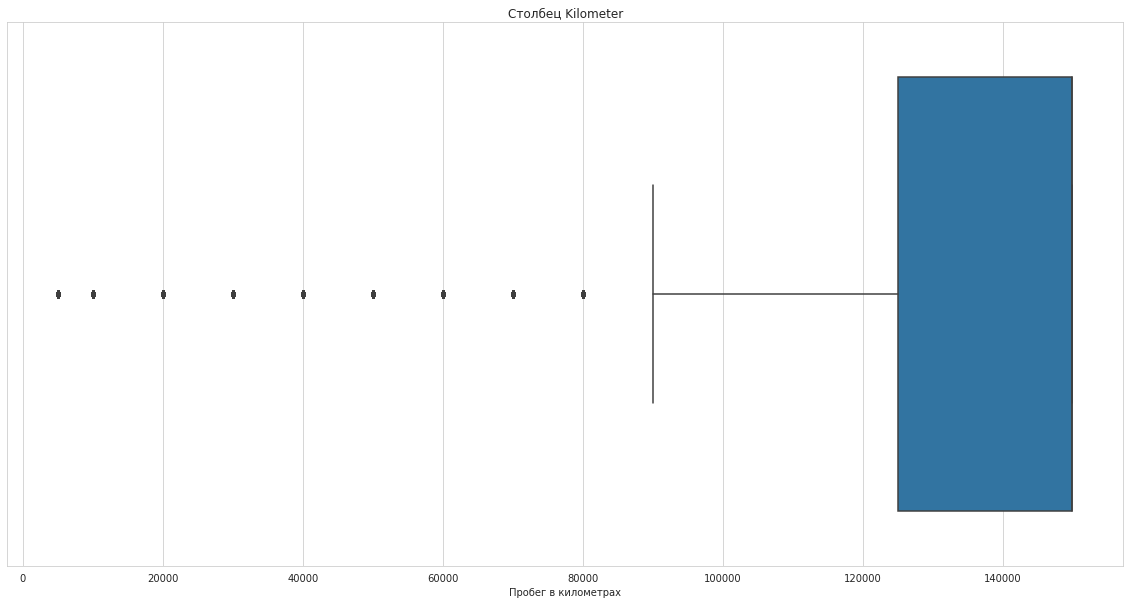

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_style('whitegrid')
sns.boxplot(x=data['Kilometer']).set(title='Столбец Kilometer')
ax.set(ylabel="", xlabel="Пробег в километрах")
plt.show();

По данным, полученным методом describe, и графикам мы видим, что выбросы присутствуют в столбцах Price, RegistrationYear, Power. Поочерёдно посмотрим на уникальные значения в этих столбцах и удалим аномалии.

In [ ]:
data['Price'].sort_values().unique()

array([    0,     1,     2, ..., 19998, 19999, 20000])

Есть совсем низкие значения цены около нуля. Пусть минимальное реальное значение цены будет 2000 евро - посмотрим на количество строк с ценой ниже 2000 евро и удалим их.

In [ ]:
print('Количество строк с ценой ниже 2000 евро:', data['Price'].loc[data['Price'] < 2000].count())

Количество строк с ценой ниже 2000 евро: 147256


In [ ]:
data_new = data.loc[data['Price'] >= 2000]

In [ ]:
sorted(data_new['RegistrationYear'].unique())

[1000,
 1001,
 1500,
 1800,
 1910,
 1923,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2500,
 2900,
 3000,
 4000,
 4500,
 5000,
 5555,
 5911,
 6000,
 7000,
 7100,
 7800,
 8500,
 8888,
 9999]

Мы видим неверные значения года регистрации - как в районе 1000, так и больше 2500. Посмотрим, когда объявления были скачаны из базы - самое последнее значение примем за верхнюю границу реального диапазона года регистрации.

In [ ]:
data_new['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

Будем считать, что достоверный диапазон времени регистрации - с 1960 по 2016 год. Аналогично посмотрим на количество строк с неверными значениями года регистрации и удалим их.

In [ ]:
print('Количество строк с неверными значениями года регистрации:',
      data_new['RegistrationYear'].loc[((data_new['RegistrationYear'] < 1960) | (data_new['RegistrationYear'] > 2016))].count())

Количество строк с неверными значениями года регистрации: 7103


In [ ]:
data_new = data_new.loc[((data_new['RegistrationYear'] >= 1960) & (data_new['RegistrationYear'] <= 2016))]

Столбец DateCrawled нам больше не нужен - удалим его.

In [ ]:
data_new = data_new.drop(columns=['DateCrawled'])

Далее посмотрим на столбец Power. Мощность двигателя большинства автомобилей, даже спортивных, не превышает 1000 л.с. Примем это значение за максимальное. Минимальное значение в среднем равно 80 л.с. Аналогично посмотрим на количество строк с неправдоподобными значениями мощности двигателя и удалим их.

In [ ]:
print('Количество строк с неверными значениями мощности:',
     data_new['Power'].loc[((data_new['Power'] < 80) | (data_new['Power'] > 1000))].count())

Количество строк с неверными значениями мощности: 37635


In [ ]:
data_new = data_new.loc[((data_new['Power'] >= 80) & (data_new['Power'] <= 1000))]

In [ ]:
print('Количество удалённых строк:', data.shape[0] - data_new.shape[0])

Количество удалённых строк: 191994


### Разделение на выборки и масштабирование непрерывных признаков

Выделим обучающую и тестовую выборки в соотношении 75:25, масштабируем непрерывные и закодируем категориальные признаки.

In [ ]:
target = data_new['Price']
features = data_new.drop('Price', axis=1)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                      test_size=0.25, random_state=12345)

In [ ]:
#выделим категориальные и непрерывные признаки
cat_features = features_train.select_dtypes(include='object').columns.to_list()
print(cat_features)
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
['RegistrationYear', 'Power', 'Kilometer']


In [ ]:
features_train_linear = features_train.copy()
features_test_linear = features_test.copy()

In [ ]:
#закодируем категориальные признаки обучающей выборки для линейной регрессии с помощью OneHotEncoder
encoder_ohe = OneHotEncoder(drop='first', sparse=False)

encoder_ohe.fit(features_train_linear[cat_features])

features_train_linear[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_linear[cat_features])

features_train_linear = features_train_linear.drop(cat_features, axis=1)

#теперь масштабируем непрерывные признаки

scaler = StandardScaler()

features_train_linear[num_features] = scaler.fit_transform(features_train_linear[num_features])

#выведем первые пять строк получившегося датафрейма
features_train_linear.head()

,RegistrationYear,Power,Kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,...,x4_skoda,x4_smart,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_volkswagen,x4_volvo,x5_unknown,x5_yes
106805,-2.288662,-0.283387,0.659978,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281387,-0.006482,-1.106121,0.659978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246543,1.397936,-0.819121,-0.653156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
351182,1.222384,-0.149454,-2.491542,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
269479,0.344622,-0.149454,0.659978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#теперь закодируем категориальные признаки тестовой выборки для линейной регрессии
features_test_linear[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test_linear[cat_features])

features_test_linear = features_test_linear.drop(cat_features, axis=1)

#теперь масштабируем непрерывные признаки
features_test_linear[num_features] = scaler.transform(features_test_linear[num_features])

#выведем первые пять строк получившегося датафрейма
features_test_linear.head()

,RegistrationYear,Power,Kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,...,x4_skoda,x4_smart,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_volkswagen,x4_volvo,x5_unknown,x5_yes
288064,1.046832,-0.819121,-1.178409,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
183582,0.871279,3.026680,0.003411,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101952,1.397936,-0.225987,-2.228916,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
18072,-1.059796,1.438613,0.659978,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
294280,0.344622,1.342946,0.003411,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
features_train_boosting = features_train.copy()
features_test_boosting = features_test.copy()

In [ ]:
#повсторим процедуру для признаков для бустинговых моделей
#кодировать будем с помощью OrdinalEncoder
encoder_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

features_train_boosting[cat_features] = encoder_ordinal.fit_transform(features_train_boosting[cat_features])

#теперь масштабируем непрерывные признаки

scaler = StandardScaler()

features_train_boosting[num_features] = scaler.fit_transform(features_train_boosting[num_features])

#выведем первые пять строк получившегося датафрейма
features_train_boosting.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
106805,1.0,-2.288662,1.0,-0.283387,19.0,0.659978,6.0,1.0,0.0
281387,8.0,-0.006482,1.0,-1.106121,99.0,0.659978,2.0,10.0,0.0
246543,0.0,1.397936,1.0,-0.819121,112.0,-0.653156,2.0,37.0,2.0
351182,3.0,1.222384,1.0,-0.149454,158.0,-2.491542,2.0,37.0,0.0
269479,8.0,0.344622,1.0,-0.149454,147.0,0.659978,2.0,10.0,0.0


In [ ]:
#теперь закодируем категориальные признаки тестовой выборки для линейной регрессии
features_test_boosting[cat_features] = encoder_ordinal.transform(features_test_boosting[cat_features])

#теперь масштабируем непрерывные признаки
features_test_boosting[num_features] = scaler.transform(features_test_boosting[num_features])

#выведем первые пять строк получившегося датафрейма
features_test_boosting.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
288064,7.0,1.046832,1.0,-0.819121,210.0,-1.178409,2.0,37.0,0.0
183582,1.0,0.871279,0.0,3.026680,11.0,0.003411,6.0,2.0,0.0
101952,5.0,1.397936,1.0,-0.225987,158.0,-2.228916,6.0,35.0,2.0
18072,6.0,-1.059796,0.0,1.438613,70.0,0.659978,6.0,14.0,1.0
294280,2.0,0.344622,1.0,1.342946,11.0,0.003411,6.0,2.0,1.0


**Вывод:** мы изучили и подготовили данные к машинному обучению:
- удалили неинформативные столбцы
- заполнили пропуски
- удалили полные дубликаты
- удалили аномалии
- закодировали категориальные признаки
- разделили данные на обучающую и тестовую выборки в соотношении 75:25 и масштабировали признаки

## Обучение моделей

Обучим четыре модели: линейную регрессию, случайный лес, CatBoost и LightGBM. Выбирать лучшие значения гиперпараметров будем с помощью GridSearchCV. По условиям исследования для оценки качества моделей необходимо использовать метрику RMSE, и её значение должно быть меньше 2500.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

### Линейная регрессия

In [ ]:
model_lr = LinearRegression()

In [ ]:
param_grid_lr = {}
grid = GridSearchCV(model_lr, param_grid_lr, cv=5, scoring='neg_root_mean_squared_error', verbose=False)
grid.fit(features_train_linear, target_train)
print("RMSE лучшей модели линейной регрессии:", -grid.best_score_)

RMSE лучшей модели линейной регрессии: 2817.7990299526737


In [ ]:
#засечём время обучения

%time
model_lr.fit(features_train_linear, target_train)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.2 µs


LinearRegression()

In [ ]:
#засечём время предсказания
%time
predictions_lr = model_lr.predict(features_train_linear)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 7.87 µs


RMSE линейной регрессии 2817.7990299526737 превышает пороговое значение, поэтому эту модель далее рассматривать мы не будем.

### Случайный лес

In [ ]:
model_rf = RandomForestRegressor(random_state=12345)

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 30, 50]
}

grid = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', verbose=False)
grid.fit(features_train_boosting, target_train)
print('Лучшие гиперпараметры:', grid.best_params_)
print("RMSE лучшей модели RandomForestRegressor:",  -grid.best_score_)

Лучшие гиперпараметры: {'max_depth': 30, 'n_estimators': 200}
RMSE лучшей модели RandomForestRegressor: 1866.2345249437433


In [ ]:
#засечём время обучения

%time
model_rf_tuned = RandomForestRegressor(random_state=12345, max_depth=30, n_estimators=200)
model_rf_tuned.fit(features_train_boosting, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


RandomForestRegressor(max_depth=30, n_estimators=200, random_state=12345)

In [ ]:
#засечём время предсказания
%time
predictions_rf = model_rf_tuned.predict(features_train_boosting)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


Время обучения модели составило 5.25, время предсказания - 5.96, RMSE RandomForestRegressor с подобранными гиперпараметрами - 1866.2345249437433.

### CatBoost

In [ ]:
model_cb = catboost.CatBoostRegressor(random_state=12345)

In [ ]:
#подберём гиперпараметры

param_grid_cb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 10],
    'iterations': [30, 50, 100]
}

grid = GridSearchCV(model_cb, param_grid_cb, cv=5, scoring='neg_root_mean_squared_error', verbose=False)
grid.fit(features_train_boosting, target_train)
print('Лучшие гиперпараметры:', grid.best_params_)
print("RMSE лучшей модели CatBoost:",  -grid.best_score_)

0:	learn: 4572.8345525	total: 65.9ms	remaining: 1.91s
1:	learn: 4549.2482974	total: 80ms	remaining: 1.12s
2:	learn: 4525.8269103	total: 91.9ms	remaining: 827ms
3:	learn: 4502.9232667	total: 104ms	remaining: 678ms
4:	learn: 4480.1954527	total: 117ms	remaining: 584ms
5:	learn: 4457.3061436	total: 129ms	remaining: 517ms
6:	learn: 4435.2381272	total: 141ms	remaining: 464ms
7:	learn: 4413.1210144	total: 153ms	remaining: 421ms
8:	learn: 4391.7112383	total: 165ms	remaining: 384ms
9:	learn: 4370.2712973	total: 176ms	remaining: 352ms
10:	learn: 4348.9324189	total: 188ms	remaining: 325ms
11:	learn: 4328.2358233	total: 199ms	remaining: 299ms
12:	learn: 4307.6552383	total: 211ms	remaining: 275ms
13:	learn: 4287.2400919	total: 222ms	remaining: 253ms
14:	learn: 4267.1821119	total: 233ms	remaining: 233ms
15:	learn: 4247.5429142	total: 244ms	remaining: 214ms
16:	learn: 4228.3235310	total: 255ms	remaining: 195ms
17:	learn: 4208.7501672	total: 266ms	remaining: 178ms
18:	learn: 4189.6736080	total: 278ms	

In [ ]:
#обучим модель с получившимися гиперпараметрами и засечём время обучения

%time
model_cb_tuned = catboost.CatBoostRegressor(random_state=12345, depth=10, iterations=100, learning_rate=0.1)
model_cb_tuned.fit(features_train_boosting, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
0:	learn: 4303.2244331	total: 46.4ms	remaining: 4.59s
1:	learn: 4043.7213716	total: 83.8ms	remaining: 4.11s
2:	learn: 3818.5370536	total: 119ms	remaining: 3.86s
3:	learn: 3624.1321047	total: 175ms	remaining: 4.19s
4:	learn: 3447.4836095	total: 209ms	remaining: 3.98s
5:	learn: 3296.2399730	total: 246ms	remaining: 3.85s
6:	learn: 3163.9290197	total: 286ms	remaining: 3.8s
7:	learn: 3046.0480093	total: 322ms	remaining: 3.7s
8:	learn: 2943.1049582	total: 357ms	remaining: 3.61s
9:	learn: 2850.9044154	total: 393ms	remaining: 3.53s
10:	learn: 2773.5741800	total: 428ms	remaining: 3.46s
11:	learn: 2700.6603049	total: 463ms	remaining: 3.4s
12:	learn: 2638.5860492	total: 498ms	remaining: 3.33s
13:	learn: 2584.6451493	total: 535ms	remaining: 3.29s
14:	learn: 2538.2809830	total: 571ms	remaining: 3.23s
15:	learn: 2492.1336024	total: 607ms	remaining: 3.19s
16:	learn: 2454.9209646	total: 647ms	remaining: 3.16s
17:	learn: 2418.4951993	total

In [ ]:
#засечём время предсказания

%time
predictions_cb = model_cb_tuned.predict(features_train_boosting)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


Время обучения модели составило 5.96, время предсказания - 6.2, RMSE CatBoost с подобранными гиперпараметрами - 1965.4294153424805.

### LightGBM

In [ ]:
model_lgbm = lightgbm.LGBMRegressor(random_state=12345)

In [ ]:
#подберём гиперпараметры

param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 10]
}

grid = GridSearchCV(model_lgbm, param_grid_lgbm, cv=5, scoring='neg_root_mean_squared_error', verbose=False)
grid.fit(features_train_boosting, target_train)
print('Лучшие гиперпараметры:', grid.best_params_)
print("RMSE лучшей модели LightGBM:",  -grid.best_score_)

Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': 10}
RMSE лучшей модели LightGBM: 1956.186470672838


In [ ]:
#обучим модель с получившимися гиперпараметрами и засечём время обучения

%time
model_lgbm_tuned = lightgbm.LGBMRegressor(random_state=12345, learning_rate=0.1, max_depth=10)
model_lgbm_tuned.fit(features_train_boosting, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


LGBMRegressor(max_depth=10, random_state=12345)

In [ ]:
#засечём время предсказания

%time
predictions_lgbm = model_lgbm_tuned.predict(features_train_boosting)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


Время обучения модели составило 6.2, время предсказания - 6.2, RMSE LightGBM с подобранными гиперпараметрами: 1956.186470672838.

**Вывод:** мы обучили четыре модели - линейную регрессию, случайный лес, CatBoost и LightGBM, подобрали для них лучшие значения гиперпараметров, а также засекли время обучения и время предсказания и вычислили значение RMSE.

## Анализ моделей

По итогам обучения моделей:

- значение RMSE **линейной регрессии** 2817.7990299526737 превышает пороговое значение, поэтому эту модель далее рассматривать мы не будем
- для **случайного леса** время обучения модели составило 5.25, время предсказания - 5.96, RMSE - 1866.2345249437433
- для **CatBoost** время обучения модели составило 5.96, время предсказания - 6.2, RMSE - 1965.4294153424805
- для **LightGBM** время обучения модели составило 6.2, время предсказания - 6.2, RMSE - 1956.186470672838

Как мы видим, время обучения и время предсказания, а также значение RMSE у случайного леса самые низкие, что и важно заказчику. Выберем эту модель для проверки на тестовой выборке.

In [ ]:
#сделаем предсказания на тестовой выборке и вычислим RMSE

%time
predictions_rf_test = model_rf_tuned.predict(features_test_boosting)
print("RMSE случайного леса на тестовой выборке:",  mean_squared_error(target_test, predictions_rf_test) ** 0.5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
RMSE случайного леса на тестовой выборке: 1807.416126564876


Значение RMSE 1807.416126564876 ниже порогового. Проверим модель на адекватность, сравнив наше значение RMSE с RMSE константной модели, которая всегда предсказывает среднее значение целевого признака.

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_boosting, target_train)
dummy_predictions = dummy_regr.predict(features_test_boosting)
print("RMSE константной модели на тестовой выборке:",  mean_squared_error(target_test, dummy_predictions) ** 0.5)

RMSE константной модели на тестовой выборке: 4574.900102258362


Модель прошла проверку на адекватность. Следовательно, стоит выбрать модель случайного леса с гиперпараметрами max_depth=30 и n_estimators=200.

## Вывод

Мы провели исследование для сервиса по продаже автомобилей с пробегом «Не бит, не крашен». Целью исследования был подбор модели, которая вычисляет рыночную стоимость автомобиля.

В ходе исследования мы:

1) Изучили и подготовили данные к машинному обучению: удалили неинформативные столбцы, заполнили пропуски, удалили полные дубликаты, удалили аномалии, закодировали категориальные признаки, разделили данные на обучающую  и тестовую выборки в соотношении 75:25 и масштабировали признаки.

2) Обучили четыре модели: линейную регрессию, случайный лес, CatBoost и LightGBM. Выбирали лучшие значения гиперпараметров с помощью GridSearchCV. По условиям исследования для оценки качества моделей мы использовали метрику RMSE, и её значение должно было составить меньше 2500.

Критерии, которые важны заказчику, и на которые мы опирались при выборе наиболее подходящей модели:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

3) По итогам обучения моделей:
- значение RMSE линейной регрессии 2817.7990299526737 превышает пороговое значение, поэтому эту модель далее рассматривать мы не стали
- для случайного леса с гиперпараметрами max_depth=30 и n_estimators=200 время обучения модели составило 5.25, время предсказания - 5.96, RMSE - 1866.2345249437433
- для CatBoost с гиперпараметрами depth=10, iterations=100, learning_rate=0.1 время обучения модели составило 5.96, время предсказания - 6.2, RMSE - 1965.4294153424805
- для LightGBM с гиперпараметрами learning_rate=0.1 и max_depth=10 время обучения модели составило 6.2, время предсказания - 6.2, RMSE - 1956.186470672838
Как мы видим, время обучения и время предсказания, а также значение RMSE у случайного леса самые низкие, что и важно заказчику. Поэтому мы выбрали эту модель для проверки на тестовой выборке.

4) Проверили модель на тестовой выборке и получили значение RMSE 1807.416126564876. Также мы проверили модель на адекватность, сравнив её с константной. Модель прошла проверку на адекватность.

Таким образом, **стоит выбрать модель случайного леса с гиперпараметрами max_depth=30 и n_estimators=200.**